In [99]:
import pandas as pd
import wbdata
import datetime
import os
import matplotlib.pyplot as plt
os.chdir("C:/Users/chris/Documents/EPA/Economics of cyber security/Data analysis project/econ_sec-master")

## Test Data
Importing tests of CAIDA and calculating percentage scores of countries in their mitigation of IP-spoofing

In [100]:
test_df = pd.read_csv("recent_tests.csv", sep=';', dtype={'Sesssion': 'str'})

#Resetting types
test_df.astype({'Timestamp': 'str',
                'Client IP Block': 'str',
                'ASN': 'str', 
                'Country': 'str', 
                'NAT': 'str', 
                'Outbound Private Status': 'str',
               'Adjacent Spoof Prefix Length': 'str'}).dtypes

df_blocked = test_df.loc[test_df['Outbound Routable Status'] == 'blocked']
df_received = test_df.loc[test_df['Outbound Routable Status'] == 'received']

C:\Users\chris\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
def column_percentage(df1, df2, column, threshold=0):
    blocked_countries = df1[column].unique().tolist()
    received_countries = df2[column].unique().tolist()
    
    country_list = []
    percentages = []
    
    for val in received_countries:
        received_country_df = df2.loc[df2[column] == val]
        if val in blocked_countries:
            blocked_country_df = df1.loc[df1[column] == val]
            
            if received_country_df.shape[0] > threshold:
                percentage = round((received_country_df.shape[0]/(blocked_country_df.shape[0] + received_country_df.shape[0])) *100, 2)
                percentages.append(percentage)
                
                country_list.append(val)
            
        else:
            if received_country_df.shape[0] > threshold:
                percentages.append(100)
                country_list.append(val)
        
    return pd.DataFrame({'Percentage mitigation':percentages}, index=country_list)
        
df_percentages = column_percentage(df_blocked, df_received, 'Country')

In [102]:
#read worldbank GDP data
data_date = datetime.datetime(2019, 1, 1)
df_GDP = wbdata.get_dataframe({'NY.GDP.MKTP.CD':'GDP'}, country='all', data_date=data_date)

#read IDI scores
df_idi = pd.read_csv("IDI_2017_Rank.csv", sep=';', index_col=1)

## Merging dataframes
Merge the different datasources into one dataframe

In [103]:
for i in df_GDP.index:
    for j in df_percentages.index:
        if i in j:
            df_percentages.loc[j,'GDP'] = df_GDP.loc[i,'GDP']

for i in df_idi.index:
    for j in df_percentages.index:
        if i in j:
            df_percentages.loc[j,'IDI'] = df_idi.loc[i,'IDI 2017 Value']
            
df_percentages = df_percentages.dropna()

## Plotting
Plotting GDP and IDI score to test for correlation.

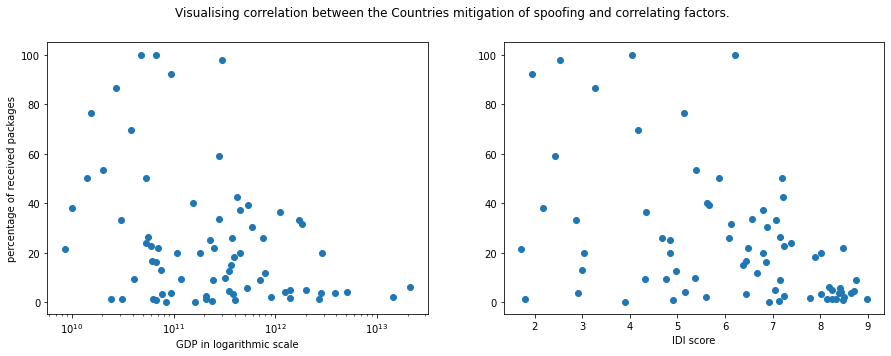

In [104]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.scatter(df_percentages.iloc[:,1],df_percentages.iloc[:,0])
ax2.scatter(df_percentages.iloc[:,2],df_percentages.iloc[:,0])

ax1.set_xscale('log')
ax1.set(ylabel="percentage of received packages", xlabel="GDP in logarithmic scale")
ax2.set(xlabel="IDI score")

fig.suptitle('Visualising correlation between the Countries mitigation of spoofing and correlating factors.')

fig.savefig('visualisation_of_correlation.png')